## Saatlik Enerji Talebi Üretimi Hava Durumu

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
weather = pd.read_csv('weather_features.csv')
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.4750,270.4750,270.4750,1001,77,1,62,0.0000,0.0000,0.0000,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.4750,270.4750,270.4750,1001,77,1,62,0.0000,0.0000,0.0000,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.6860,269.6860,269.6860,1002,78,0,23,0.0000,0.0000,0.0000,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.6860,269.6860,269.6860,1002,78,0,23,0.0000,0.0000,0.0000,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.6860,269.6860,269.6860,1002,78,0,23,0.0000,0.0000,0.0000,0,800,clear,sky is clear,01n


In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [4]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,178396.0000,289.6186,8.0262,262.2400,283.6700,289.1500,295.1500,315.6000
temp_min,178396.0000,288.3304,7.9555,262.2400,282.4836,288.1500,293.7301,315.1500
temp_max,178396.0000,291.0913,8.6125,262.2400,284.6500,290.1500,297.1500,321.1500
pressure,178396.0000,1069.2607,5969.6319,0.0000,1013.0000,1018.0000,1022.0000,1008371.0000
humidity,178396.0000,68.4235,21.9029,0.0000,53.0000,72.0000,87.0000,100.0000
wind_speed,178396.0000,2.4706,2.0959,0.0000,1.0000,2.0000,4.0000,133.0000
wind_deg,178396.0000,166.5912,116.6119,0.0000,55.0000,177.0000,270.0000,360.0000
rain_1h,178396.0000,0.0755,0.3988,0.0000,0.0000,0.0000,0.0000,12.0000
rain_3h,178396.0000,0.0004,0.0073,0.0000,0.0000,0.0000,0.0000,2.3150
snow_3h,178396.0000,0.0048,0.2226,0.0000,0.0000,0.0000,0.0000,21.5000


In [5]:
weather.shape

(178396, 17)

In [6]:
weather.isnull().sum()

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [7]:
weather.city_name.value_counts()

Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city_name, dtype: int64

In [8]:
energy = pd.read_csv('energy_dataset.csv')
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0000,329.0000,0.0000,4844.0000,4821.0000,162.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,6378.0000,17.0000,NaN,6436.0000,26118.0000,25385.0000,50.1000,65.4100
1,2015-01-01 01:00:00+01:00,449.0000,328.0000,0.0000,5196.0000,4755.0000,158.0000,0.0000,0.0000,0.0000,...,195.0000,0.0000,5890.0000,16.0000,NaN,5856.0000,24934.0000,24382.0000,48.1000,64.9200
2,2015-01-01 02:00:00+01:00,448.0000,323.0000,0.0000,4857.0000,4581.0000,157.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,5461.0000,8.0000,NaN,5454.0000,23515.0000,22734.0000,47.3300,64.4800
3,2015-01-01 03:00:00+01:00,438.0000,254.0000,0.0000,4314.0000,4131.0000,160.0000,0.0000,0.0000,0.0000,...,191.0000,0.0000,5238.0000,2.0000,NaN,5151.0000,22642.0000,21286.0000,42.2700,59.3200
4,2015-01-01 04:00:00+01:00,428.0000,187.0000,0.0000,4130.0000,3840.0000,156.0000,0.0000,0.0000,0.0000,...,189.0000,0.0000,4935.0000,9.0000,NaN,4861.0000,21785.0000,20264.0000,38.4100,56.0400


In [9]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [10]:
energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.0000,35046.0000,35046.0000,35046.0000,35046.0000,35045.0000,35046.0000,35046.0000,35046.0000,0.0000,...,35045.0000,35046.0000,35046.0000,35064.0000,0.0000,35064.0000,35064.0000,35028.0000,35064.0000,35064.0000
mean,383.5135,448.0592,0.0000,5622.7375,4256.0657,298.3198,0.0000,0.0000,0.0000,NaN,...,269.4521,0.0000,5464.4798,1439.0667,NaN,5471.2167,28712.1300,28696.9399,49.8743,57.8840
std,85.3539,354.5686,0.0000,2201.8305,1961.6010,52.5207,0.0000,0.0000,0.0000,NaN,...,50.1955,0.0000,3213.6916,1677.7034,NaN,3176.3129,4594.1009,4574.9880,14.6189,14.2041
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,...,0.0000,0.0000,0.0000,0.0000,NaN,237.0000,18105.0000,18041.0000,2.0600,9.3300
25%,333.0000,0.0000,0.0000,4126.0000,2527.0000,263.0000,0.0000,0.0000,0.0000,NaN,...,240.0000,0.0000,2933.0000,69.0000,NaN,2979.0000,24793.7500,24807.7500,41.4900,49.3475
50%,367.0000,509.0000,0.0000,4969.0000,4474.0000,300.0000,0.0000,0.0000,0.0000,NaN,...,279.0000,0.0000,4849.0000,576.0000,NaN,4855.0000,28906.0000,28901.0000,50.5200,58.0200
75%,433.0000,757.0000,0.0000,6429.0000,5838.7500,330.0000,0.0000,0.0000,0.0000,NaN,...,310.0000,0.0000,7398.0000,2636.0000,NaN,7353.0000,32263.2500,32192.0000,60.5300,68.0100
max,592.0000,999.0000,0.0000,20034.0000,8359.0000,449.0000,0.0000,0.0000,0.0000,NaN,...,357.0000,0.0000,17436.0000,5836.0000,NaN,17430.0000,41390.0000,41015.0000,101.9900,116.8000


In [11]:
nRow, nCol = energy.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 35064 rows and 29 columns


In [12]:
energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [14]:
energy.time.min(),energy.time.max()

('2015-01-01 00:00:00+01:00', '2018-12-31 23:00:00+01:00')

In [15]:
mape = np.mean(np.abs((energy['total load actual'] - energy['total load forecast']) / energy['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 1.0960230737238263


In [16]:
temp = energy.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


### AR Model

In [17]:
from statsmodels.tsa.ar_model import AR #AutoRegressive

model = AR(train)
model_fit = model.fit()

In [18]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3729.2644250787775
Test Root Mean Squared Error: 4391.073081234294


In [19]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(Y_test, test_predict)*100
print(mape)
#mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
#print("Testing MAPE: {}".format(mape))

372926.4425078778


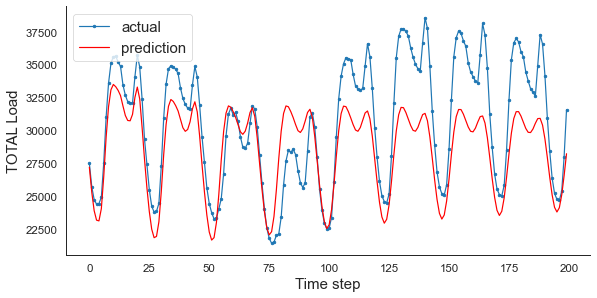

In [20]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [21]:
test_predict = np.mean(X_test, axis=2)
print('Test Mean Absolute Error:', mean_absolute_error(testY, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(testY, test_predict)))

Test Mean Absolute Error: 0.14497761
Test Root Mean Squared Error: 0.17464507


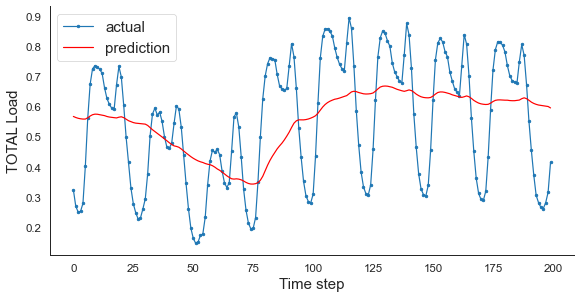

In [24]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### ARMA Model

In [25]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)

In [26]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3862.9291157837033
Test Root Mean Squared Error: 4521.711437250732


In [27]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 13.815133756759238


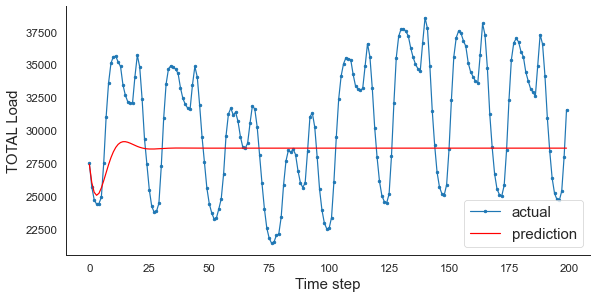

In [28]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### ARIMA Model

In [29]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=False)

In [30]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 10816.588591220003
Test Root Mean Squared Error: 11722.243285207658


In [31]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 35.88114051994509


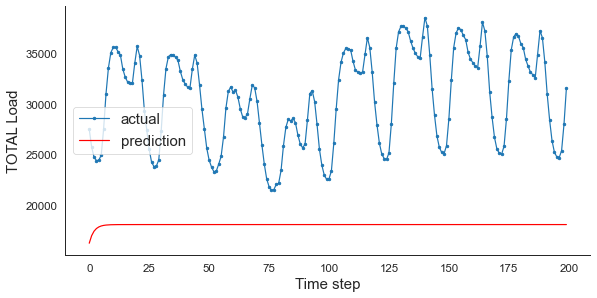

In [32]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### LSTM Model

In [33]:
temp = energy
dataset = temp['total load actual'].dropna().values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [34]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Epoch 1/50
400/400 [==============================] - 9s 7ms/step - loss: 0.0311 - val_loss: 0.0032
Epoch 2/50
400/400 [==============================] - 4s 9ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 3/50
400/400 [==============================] - 2s 4ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/50
400/400 [==============================] - 4s 11ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 6/50
400/400 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 9.9671e-04
Epoch 7/50
400/400 [==============================] - 2s 4ms/step - loss: 0.0019 - val_loss: 9.4152e-04
Epoch 8/50
400/400 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 9.4694e-04
Epoch 9/50
400/400 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/50
400/400 [==============================] - 1s 4ms/step - loss: 0.0017 - val

In [35]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 381.0516227578577
Train Root Mean Squared Error: 612.3194862171298
Test Mean Absolute Error: 358.5503394857303
Test Root Mean Squared Error: 575.3724622134672


In [36]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train MAPE: 1.3565226998055349, Test MAPE: 1.2639970413317074


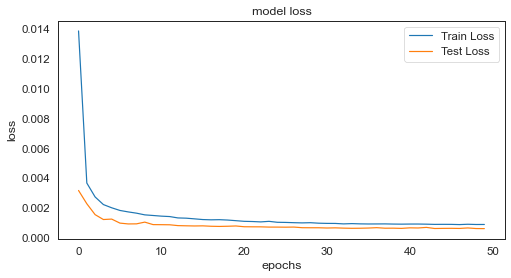

In [37]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

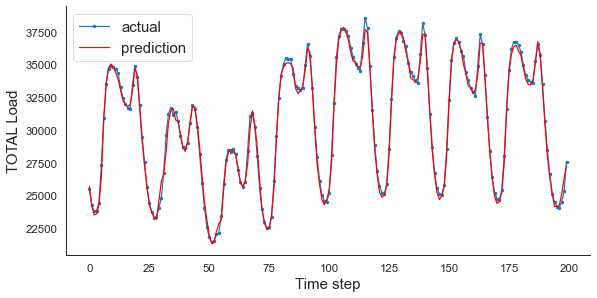

In [38]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();